# Data Re-Uploading for a Universal Quantum Classifier

This is an impelmentation of of the paper https://arxiv.org/abs/1907.02085 by Perez-Salinas *et al*, here they make the analogy of a classical feed-forward neural network with a quantum circuit used for classification. A neuron in a layer of a classical neural network (NN), $L_N$, can be given as

\begin{align}
N_{l,j} = \phi_{l,j} \left(\sum_i w_{l,i,j} \phi_{1-1}(\dots)\right),
\end{align}

where $i$ runs over the index of all neurons (or input) in the previous layer, $x$ is an d-dimensional input vector, $\phi(\dots)$ is the transfer function, and $w_l$ is the parameteriszable input weight matrix for layer $l$.

In the first layer of a NN the input vector $x$ is given as an indepedently weighted input to each of the transfer functions in the first processing layer, it is here that Perez-Salinas *et al* make their analogy. They suggest that to imitate this multiple usage of the input vector a quantum function of the input vector, given by the unitary $U(\vec{x})$, should be applied at each layer $L(i)$. The quantum transfer function a each layer is defined as a paramterisable unitary $U(\vec{\theta}_i)$. The combined action of each layer on the input state $|\psi\rangle_{i}$ is then given as

\begin{align}
L(i) \equiv U(\vec{x})U(\vec{\theta}_i)
|\psi_{i+1}\rangle &= L(i)|\psi_{i}\rangle, \\
|\psi_{0}\rangle &= |0\rangle.
\end{align}

The action of the whole classifier circuit, $\mathcal{U}$, for a classical input, $x$, can therefore be given as the sequence of $N$ layers

\begin{align}
\mathcal{U}(\vec{\theta},\vec{x}) = L(N)\dots L(0)|0\rangle .
\end{align}

Comparing this to the first layer of a classical NN it can be seen that the main difference is that each of the processing units in the quantum classifer acts on the output of the previous, as such a better classical analogy would be to training techniques in deep learning where the original input $x$ is injected into some layers.

The action of the layers can be extended and reduced to a single rotation operator, with the input vector weighted by a set of parameterisable weights $\vec{w}$

\begin{align}
L_w(i) &= U(\vec{\theta}_i + \vec{w}_i\vec{x}) \\
\mathcal{U}_w(\vec{\theta},\vec{w},\vec{x}) &= L_w(N) \dots L_w(0)|0\rangle .
\end{align}

We will refer to the first classifier as the *single-qubit-classifier* and the later as *single-qubit-weighted-classifier*.

## Training

The circuit $U(x,\theta)$ is a varitional circuit and relies upon the paramters $\theta$ to be learnt, this is done using a classical optimisation algorithm. The cost function to be optimised is a function of the fidelity, $F(|\phi\rangle,|\psi\rangle)$, between two states. In this application the fidelity is measured between the output state of the quantum classifier, $|\psi_N\rangle$, and the binary target label for the $m$th input $|\tilde{\psi_m}\rangle \in \{|0\rangle,|1\rangle\}$, to make this a minimisation problem we take the complement of the fidelity. Over a set of $M$ training inputs the cost function for a paramaterisation $U(\left( \theta,w\right)$ is 

\begin{align}
\chi^2(\theta, w) = \sum^M_{m=0}1-|\langle\psi_N|\tilde{\psi_m}\rangle|^2 .
\end{align}

To measure the fideltiy of the circuit we need to find the expectation of a measurement operator $O$:

\begin{align}
F(|\psi\rangle,|\tilde{\psi}\rangle) = |\langle\psi|\tilde{\psi}\rangle|^2 = \langle\psi|\tilde{\psi}\rangle\langle\tilde{\psi}|\psi\rangle ,
\end{align}

thus is can be seen the operator $O$ is the projector of the classification label.


##  Single Qubit Classifier

We first begin with the single qubit classifier. In this implementation we try to keep the idea of classication classes generalied by using dictionary maps, this relaxes the constraint that classes have to be defined by an integer.

### Binary Classiciation

First we look at the performance for binary classification, where each point is classified as $y_m \in \{0,1\}$.

In [157]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import autograd.numpy as anp
import matplotlib.pyplot as plt
import pandas as pd

In [158]:
dev = qml.device("default.qubit", wires=1)

"""
First define the quantum circuit backends
"""

@qml.qnode(dev)
def qcircuit(params, x=None, y=None):
    """ Simple circuit backend for the single qubit classifier

    This is the most basic version of a single qubit classifier, it implements each layer
    as a sequence of U(x)U(theta).

    Args:
        params (iter): Iterable of rotation parameters theta_l = (theta_1, theta_2, theta_2).
        x (iter): Data point.
        y (Array): Target measure, Hermitian matrix to measure the fidelity output.

    Returns:
        float: Expectation of the measure, fidelity of the network output and target measure.
    """

    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))
    

@qml.qnode(dev)
def qcircuit_2(params, x=None, y=None):
    """ Circuit backend for the single qubit classifier
    
    Implements each layer as a single rotation U(phi), where theta has been classically 
    preprocessed as phi = theta + w*x.
    
    Args:
        params (iter): Iterable of rotation parameters phi_l = (phi_1, phi_2, phi_2).
        y (Array): Target measure, Hermitian matrix to measure the fidelity output.

    Returns:
        float: Expectation of the measure, fidelity of the network output and target measure.
    """
    
    for p in params:
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

"""
Define the classifiers (In productions we would want to use proper abstract classes and inheritance)
"""

class SingleQubitClassifier():
    """Simple single qubit classifier
    """
    
    def __init__(self, layers=1):
        self.layers=layers
    
    def execute(self, params, x, y):
        """ Execute the classifier for a sample
        
        Args:
            params (iter): Iterable of rotation parameters theta_l = (theta_1, theta_2, theta_2).
            x (iter): Data point.
            y (Array): Target measure, Hermitian matrix to measure the fidelity output.

        Returns:
            float: Expectation of the measure, fidelity of the network output and target measure.
        
        """
        
        return qcircuit(params[0], x=x, y=y)
    
    def get_params_dim(self):
        """ Get dimensions of parameters to train
        
        Returns:
            list[tuples]: List of tuples of parameter matrices
        """
        return [(self.layers, 3)]

    
class SingleQubitWeightedClassifier():
    """ Single qubit classifier with weighted sample input
    """

    def __init__(self, layers=1):
        self.layers=layers
        
    def execute(self, params, x, y):
        """ Execute the classifier for a sample
        
        Args:
            params (iter): Iterable of rotation parameters theta_l = (theta_1, theta_2, theta_2).
            x (iter): Data point.
            y (Array): Target measure, Hermitian matrix to measure the fidelity output.

        Returns:
            float: Expectation of the measure, fidelity of the network output and target measure.
        
        """
        mask = np.zeros(shape=(len(params[1]),3))
        for i in range(len(mask)):
            mask[i] = x 
        return qcircuit_2(anp.add(params[0], anp.multiply(mask, params[1])), y=y)
    
    def get_params_dim(self):
        """ Get dimensions of parameters to train
        
        Returns:
            list[tuples]: List of tuples of parameter matrices
        """
        return [(self.layers, 3), (self.layers, 3)]

    
def qclassifier_weighted(params, x, y):
    """ Single qubit weighted classifier. 
    
    Implements each layer as a single rotation U(phi), where theta has been classically 
    preprocessed as phi = theta + w*x, phi is precomputed and then passed to the
    quantum circuit backend (qcircuit_2) for execution.
    
    Args:
        params (iter): Iterable of rotation parameters phi_l = (phi_1, phi_2, phi_2).
        x (iter): Data point.
        y (Array): Target measure, Hermitian matrix to measure the fidelity output.

    Returns:
        float: Expectation of the measure, fidelity of the network output and target measure.
    """
#     mask = np.zeros(shape=(len(params),6))
#     for i in range(len(mask)):
#         mask[i][3:] = x  
#     anti_diag = np.flip(np.eye(6),axis=1)  
#     a = anp.add(params, anp.matmul(anp.multiply(mask, params),anti_diag))

    # create a mask to compute w*x
    mask = np.zeros(shape=(len(params[1]),3))
    for i in range(len(mask)):
        mask[i] = x 
    return qcircuit_2(anp.add(params[0], anp.multiply(mask, params[1])), y=y)


def cost_simple(params, x, y, class_map, classifier):
    """ The basic unwieghted fidelity cost function for binary classification.
    
    This calculated the cost as sum_0^M 1 - f(x_m, y)^2 .
    
    Args:
        params (iter): Parameters of the classifier.
        x (iter): Iterable of data points.
        y (Array): Iterable of data point target classes.
        class_map (dict): Map of target classes to Hermitian measure operator.
    
    Returns:
        float: Cost of the classification.
    """
    
    c = 0.0
    for i in range(len(x)):
        f = classifier.execute(params, x=x[i], y=class_map[y[i]])
        c = c + (1 - f) ** 2
    return c


def predict(params, x, class_map, classifier):
    """ Prediction for binary classification.
    
    Args:
        params (iter): Parameters of the classifier.
        x (iter): Iterable of data points.
        class_map (dict): Map of target classes to Hermitian measure operator.
    
    Returns:
        np.array: Array of predicted classes.
        np.array: Array of fidelities for predicted classes
    """
    
    y_ = []
    fid = []
    for i in range(len(x)):
        # test fidilities for all labels
        fid_i = {}
        for c, l in class_map.items():
            fid_i[c] = classifier.execute(params, x=x[i], y=l)
        y_.append(max(fid_i, key=fid_i.get))
        fid.append(fid_i)
    return np.array(y_), np.array(fid)

def accuracy_score(y_true, y_pred):
    """Accuracy score. (Ref PennyLane)

    Args:
        y_true (np.array): 1-d array of targets
        y_predicted (np.array): 1-d array of predictions
        state_labels (np.array): 1-d array of state representations for labels

    Returns:
        float: the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

In [159]:
def iterate_minibatches(inputs, targets, batch_size):
    """ A generator for batches of the input data. (Ref PennyLane)

    Args:
        inputs (np.array): input data
        targets (np.array): targets

    Returns:
        np.array: one batch of input data of length `batch_size`
        np.array: one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [160]:
def map_binary_classes(y):
    """ Map classes to Hermitian measures

    Args:
        y (np.array): Array of training targets

    Returns:
        dict: Dictionary mapping classes to Hermitian measures
    Raises:
        ValueError: Raises error if number of classes is not 2
    """
    
    classes = list(set(y))
    if len(classes) != 2:
        raise ValueError(f'Requires only 2 classes, {len(classes)} given')
    class_map = {classes[0]: [[1],[0]] * np.conj([[1],[0]]).T, classes[1]:[[0],[1]] * np.conj([[0],[1]]).T}
    return class_map


def train_binary_classifier(x, y, classifier, opt, epochs, batch=100, verbose=True):
    """ Train a quantum binary classifier.

    Args:
        x (np.array): Array of training values.
        y (np.array): Array of training targets.
        layers (int): Num of quantum layers.
        opt (optimiser): Optimiser implementing the `step()` function.
        epochs (int): Training epochs.
        batch (int): Size of training batches, deafult batch is len(x).
        
    Returns:
        param: Array of optimal parameters
    """
    # Map classes 
    class_map = map_binary_classes(y)

    params = []
    for dim in classifier.get_params_dim():
        params.append(np.random.uniform(size=dim))

    train_costs = []
    train_scores = []
    for it in range(epochs):
        for Xbatch, ybatch in iterate_minibatches(x, y, batch_size=batch_size):
            params = opt.step(lambda v: cost_simple(v, Xbatch, ybatch, class_map, classifier), params)            

        y_, fid = predict(params, x, class_map, classifier)
        score = accuracy_score(y, y_)
        cost = cost_simple(params, x, y, class_map, classifier)
        train_costs.append(cost)
        train_scores.append(score)
        if verbose:
            print(f't:{it} | cost: {cost} | accuracy: {score}')
    return params, class_map, train_costs, train_scores

##### Binary Circle Problem

We will test the binary classifier for the 2d problem, where for circle with raduis $r$, and $x_m \in \mathbb{R}^2$

\begin{align}
y_m =  \begin{cases}
      0, & \text{if}\ x_{m,1}^2 + x_{m,2}^2 \geq r \\
      1, & \text{otherwise}
    \end{cases} .
\end{align}

The optimiser used will be the Adam optimiser provided in PennyLane.

In [168]:
def circle(M, domain=[-1, 1], r=np.sqrt(2 / np.pi)):
    """ Generate classified points inside and outside of circle.
    
    Center of the circle is located at the center of the square domain,
    points are then classified as 1 if inside the circle or 0 otherwise.
    
    Args:
        domain (list): Domain for the bounding square.
        r (float): Radius of the circle.

    Returns:
        list: List of 2D points inside the domain.
        list: List of classifications for each point.    
    """

    x = (domain[1] - domain[0]) * (np.random.rand(M, 2)) + domain[0]
    y = [1 if (x_[0]**2 + x_[1]**2) < r else 0 for x_ in x]
    x = np.hstack((x, np.zeros((x.shape[0], 1))))
    return x, y

In [169]:
""" Define the classifier to use """
learning_rate = 0.9
epochs = 10
batch_size = 20

num_training = 200
num_test = 2000
x, y = circle(num_training)

# Test both classifiers
trials = 10
sqwc_opt = []
sqc_opt = []

layers = 3
sqwc = SingleQubitWeightedClassifier(layers=layers)
sqc = SingleQubitClassifier(layers=layers)

for i in range(trials):
    print(f'Beginning trial {i}')
    np.random.seed(i)
    x, y = circle(num_training)
    opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    sqc_opt.append(train_binary_classifier(x, y, sqc, opt, epochs, batch_size, verbose=False))

Beginning trial 0
Beginning trial 1
Beginning trial 2
Beginning trial 3
Beginning trial 4
Beginning trial 5
Beginning trial 6
Beginning trial 7
Beginning trial 8
Beginning trial 9


In [170]:
for i in range(trials):
    print(f'Beginning trial {i}')
    np.random.seed(i)
    x, y = circle(num_training)
    opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    sqwc_opt.append(train_binary_classifier(x, y, sqwc, opt, epochs, batch_size, verbose=False))

Beginning trial 0
Beginning trial 1
Beginning trial 2
Beginning trial 3
Beginning trial 4
Beginning trial 5
Beginning trial 6
Beginning trial 7
Beginning trial 8
Beginning trial 9


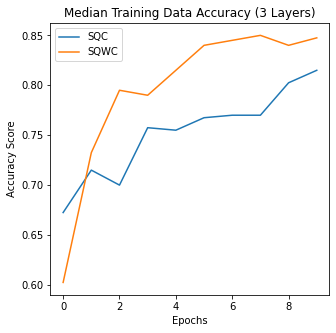

In [171]:
def get_scores(opt_results):
    """ Extract scores"""
    scores = pd.DataFrame()
    for i in range(len(opt_results)):
        scores[f'{i}'] = opt_results[i][3]
    return scores

def test_results(classifier, params, class_map, samples=10, test_size=200):
    accuracy = []
    scores = []
    for i in range(samples):
        np.random.seed(i)
        x, y = circle(test_size)
        y_, fid = predict(params, x, class_map, classifier)
        score = cost_simple(params, x, y, class_map, classifier)
        accuracy.append(accuracy_score(y, y_))
        scores.append(np.mean(score))
    return {'acc': (np.mean(accuracy), np.std(accuracy)), 'score':(np.mean(scores), np.std(scores))}
    
# Plot the median scores
sqc_scores = get_scores(sqc_opt)
sqwc_scores = get_scores(sqwc_opt)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(sqc_scores.index, sqc_scores.median(axis=1), label='SQC')
ax.plot(sqwc_scores.index, sqwc_scores.median(axis=1), label='SQWC')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy Score')
ax.set_title('Median Training Data Accuracy (3 Layers)')
ax.legend()
plt.show()

We can see from the training results, in the case a three layer network, that the single-qubit-weighted-classifier (SQWC) results in better classification accuracy, at least within training. To illistrate the classifier we will plot the output of the first SQWC on the test data.

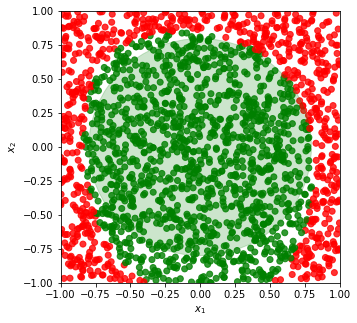

In [172]:
def plot_data(x_plt, y_plt, domain=[-1,1], c1=[np.sqrt(2 / np.pi),(0,0)]):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#     ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
#     ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")

    class_colour = {0:'r', 1:'g'}
    ax.add_patch(plt.Circle(c1[1], c1[0], color='g', alpha=0.2))
    
    ax.scatter(x_plt.T[0], x_plt.T[1], c=[class_colour[y_] for y_ in y_plt], alpha=0.8)
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.show()

x_test, y_test = circle(2000)
class_map = map_binary_classes(y)
y_, fid = predict(sqwc_opt[-1][0], x_test, class_map, sqwc)
plot_data(x_test, y_)

### Multi-Class Classifier

We can extend the model to classifying more that 2 classes. In the case of 4 classes we can define the classes as the vertices of a maximally embedded tetrahedron inside a sphere. We can then map these vertices onto points on the Bloch Sphere.

In [173]:
def map_cartesian_to_bloch_sphere(xyz):
    """ Maps cartesian point on the surface of the 3D unit sphere to 
        the state on the Bloch Sphere
    
    Args:
        xyz (list): 3-vector [x, y, z]
        
    Returns:
        np.array: 2d pure state vector
    
    """
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    if x ** 2 + y ** 2 + z ** 2 != 1:
        raise ValueError('Point needs to lie on unit sphere')
    theta = np.arccos(z)
    phi = np.arctan2(y,x)
    # get bloch vector
    ket_0 = np.cos(theta/2) * np.array([[1.0],[0.0]])
    ket_1 = (np.cos(phi) + 1j * np.sin(phi))*np.sin(theta/2) * np.array([[0.0],[1.0]])
    return ket_0 + ket_1


def map_four_classes(classes):
    """ Maps four classes to points on Bloch sphere.
    
    Maps four points to vertices of the maximally embedded tetrhedron
    in the Bloch sphere.
    
    Args:
        classes (set): Set of 4 distinct classes.
        
    Returns:
        dict: Map of classes to state on the bloch sphere.
    """
    if len(classes) != 4:
        raise ValueError('Requires exactly 4 classes')
    tet = [[np.sqrt(8./9.),0,-1/3.],
                   [-np.sqrt(2./9.), np.sqrt(2./3.), -1/3.],
                   [-np.sqrt(2./9.), -np.sqrt(2./3.), -1/3.],
                   [0.,0.,1.]]
    cm = {}
    for p, c in zip(tet, classes):
        cm[c] = map_cartesian_to_bloch_sphere(p)
    return cm


def class_overlap(class_map):
    """ Maps four classes to points on Bloch sphere.
    
    Maps four points to vertices of the maximally embedded tetrhedron
    in the Bloch sphere.
    
    Args:
        classes (set): Set of 4 distinct classes.
        
    Returns:
        dict: Map of classes to state on the bloch sphere.
    """
    keys = list(class_map.keys())
    m1 = np.concatenate((class_map[keys[0]],class_map[keys[1]]), axis=1)
    m2 = np.concatenate((class_map[keys[2]],class_map[keys[3]]), axis=1)
    m1 = np.concatenate((m1,m2), axis=1).T
    key_ind = {keys[i]:i for i in range(len(keys))}
    return np.square(np.absolute(np.matmul(m1, np.conj(m1).T,))), key_ind

#### Cost Function

The cost function originaly defined is the weighted fidelity given as

\begin{align}
\chi_w^f = \sum_{m=1}^M \sum_{c=1}^C \left(\alpha_c F_c(\vec{\theta}, \vec{w}, \vec{x}_m) - Y_c(\vec{x}_m)\right)^2,
\end{align}

where $\alpha_c$ is the class weight and is also optimised and $F_c$ is the class fidelity. However there are issues with the original formulation; first of all $\alpha_c$ is unconstrained and thus this function can easily be minimised by minimising $\alpha_c$ to low negative values. A more senesical formation of the weighted loss would be

\begin{align}
\chi_w^f = \sum_{m=1}^M \sum_{c=1}^C \alpha_c\left(F_c(\vec{\theta}, \vec{w}, \vec{x}_m) - Y_c(\vec{x}_m)\right)^2,
\end{align}

where the class weight acts on the contribution of the class's cost to the overall cost. We should then also define the normalised condition that $sum_c^C \alpha_c = 1$. In an unconstrained optimisation this can be enforced by either normalising the weights, *multiclass_cost_weighted_norm( )*, or by adding a regularization term to enforce the condition, *multiclass_cost_weighted_reg( )*. 

In [174]:
def multiclass_cost(params, x, y, class_map, cls):
    """ Multiclass cost function as originally defined
    """
    ovlp_m, key_ind = class_overlap(class_map)
    measures = {k:class_map[k] * np.conj(class_map[k]).T for k in class_map.keys()}
    ovlp_m = ovlp_m.T
    c = 0.0
    for i in range(len(x)):
        for k in class_map.keys():
            klass_idx = key_ind[k]
            f = cls.execute(params, x[i], measures[k])
            c = c + (params[-1][klass_idx]*f - ovlp_m[key_ind[y[i]]][klass_idx])**2
    return 0.5 * c

def multiclass_cost_weighted_reg(params, x, y, class_map, cls, reg=100):
    """ Multiclass cost function that regularises the weights s.t the
    """
    ovlp_m, key_ind = class_overlap(class_map)
    measures = {k:class_map[k] * np.conj(class_map[k]).T for k in class_map.keys()}
    ovlp_m = ovlp_m.T
    c = 0.0
    for i in range(len(x)):
#         f = np.zeros(shape=(len(class_map),1))
        for k in class_map.keys():
            klass_idx = key_ind[k]
            f = cls.execute(params, x[i], measures[k])
            c = c + (anp.absolute(params[-1])[klass_idx])*(f - ovlp_m[key_ind[y[i]]][klass_idx])**2
#             x_cost = np.multiply(params[-1], (f - ovlp_m[key_ind[y[i]]])**2)
#             c = c + (params[-1][klass_idx]*f - ovlp_m[key_ind[y[i]]][klass_idx])**2
    return 0.5 * c + reg * (1 - sum((anp.absolute(params[-1])))) ** 2

def multiclass_cost_weighted_norm(params, x, y, class_map, cls):
    """ Multiclass cost function that regularises the weights
    """
    ovlp_m, key_ind = class_overlap(class_map)
    measures = {k:class_map[k] * np.conj(class_map[k]).T for k in class_map.keys()}
    ovlp_m = ovlp_m.T
    c = 0.0
    for i in range(len(x)):
#         f = np.zeros(shape=(len(class_map),1))
        for k in class_map.keys():
            klass_idx = key_ind[k]
            f = cls.execute(params, x[i], measures[k])
            c = c + (anp.absolute(params[-1])/sum(anp.absolute(params[-1])))[klass_idx] * (f - ovlp_m[key_ind[y[i]]][klass_idx])**2
#             x_cost = np.multiply(params[-1], (f - ovlp_m[key_ind[y[i]]])**2)
#             c = c + (params[-1][klass_idx]*f - ovlp_m[key_ind[y[i]]][klass_idx])**2
    return 0.5*c

def multiclass_cost_weighted_fixed(params, x, y, class_map, cls, class_weights=None):
    """ Multiclass cost function that regularises the weights s.t the
    """
    cw = class_weights
    if class_weights is None:
        w = 1./len(class_map)
        cw = {klass:w for klass in class_map.keys()}
    ovlp_m, key_ind = class_overlap(class_map)
    measures = {k:class_map[k] * np.conj(class_map[k]).T for k in class_map.keys()}
    ovlp_m = ovlp_m.T
    c = 0.0
    for i in range(len(x)):
#         f = np.zeros(shape=(len(class_map),1))
        for k in class_map.keys():
            klass_idx = key_ind[k]
            f = cls.execute(params, x[i], measures[k])
            c = c + cw[k]*(f - ovlp_m[key_ind[y[i]]][klass_idx])**2
#             x_cost = np.multiply(params[-1], (f - ovlp_m[key_ind[y[i]]])**2)
#             c = c + (params[-1][klass_idx]*f - ovlp_m[key_ind[y[i]]][klass_idx])**2
    return 0.5*c

def multiclass_predict(params, x, class_map, cls):
    """ Prediction for classification.
    
    Args:
        params (iter): Parameters of the classifier.
        x (iter): Iterable of data points.
        class_map (dict): Map of target classes to Hermitian measure operator.
    
    Returns:
        np.array: Array of predicted classes.
    """
    ovlp_m, key_ind = class_overlap(class_map)
    ovlp_m = ovlp_m.T
    measures = {k:class_map[k] * np.conj(class_map[k]).T for k in class_map.keys()}
    y_ = []
    for i in range(len(x)):
        k_c = {0:0, 1:0, 2:0, 3:0}
        for k in class_map.keys():
            klass_idx = key_ind[k]
            f = cls.execute(params, x[i], measures[k])
            for k2 in class_map.keys():
                k_c[k2] = k_c[k2] + (f - ovlp_m[key_ind[k2]][klass_idx])**2   
                
        y_.append(min(k_c, key=k_c.get))
    return np.array(y_)

#### Three Circle Problem
We now define the 3 circle problem that splits the domain in 4 classes, either belonging to one of the circles or none. We use the single-qubit-weighted classifier.

In [175]:
def three_circles(M, domain=[-1,1], c1=[1,(-1,1)], c2=[0.5,(-0.5,-0.5)], c3=[1,(1,0)]):
    """ Splits the data into four classes, either inside one of the circles or not.
    
    Args:
        M (int): Number of samples.
        domain (list): Domain of the bounding square.
        c1 (list[float, tuple(float, float)]): Radius and center of the first class circle.
        c2 (list[float, tuple(float, float)]): Radius and center of the second class circle.
        c3 (list[float, tuple(float, float)]): Radius and center of the third class circle.
    
    Returns:
        np.array: Data points.
        np.array: Classification.
    
    """
    def inside(xy, center, r):
        x = xy[0]
        y = xy[1]
        r_ = (x - center[0])**2 + (y - center[1])**2
        return True if r_ <= r**2 else False
    
    x = (domain[1] - domain[0]) * (np.random.rand(M, 2)) + domain[0]
    y = []
    for i in range(len(x)):
        y.append(0)
        if inside(x[i], c1[1], c1[0]):
            y[i] = 1
        elif inside(x[i], c2[1], c2[0]):
            y[i] = 2
        elif inside(x[i], c3[1], c3[0]):
            y[i] = 3
    x = np.hstack((x, np.zeros((x.shape[0], 1))))
    return x, y

def plot_data(x_plt, y_plt, domain=[-1,1], c1=[1,(-1,1)], c2=[0.5,(-0.5,-0.5)], c3=[1,(1,0)]):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#     ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
#     ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")

    class_colour = {0:'black', 1:'r', 2:'g', 3:'b'}
    ax.add_patch(plt.Circle(c1[1], c1[0], color='r', alpha=0.1))
    ax.add_patch(plt.Circle(c2[1], c2[0], color='g', alpha=0.1))
    ax.add_patch(plt.Circle(c3[1], c3[0], color='b', alpha=0.1))
    
    ax.scatter(x_plt.T[0], x_plt.T[1], c=[class_colour[y_] for y_ in y_plt], alpha=0.8)
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.show()

Beginning training
t:0 | accuracy: 0.39
t:1 | accuracy: 0.6966666666666667
t:2 | accuracy: 0.63
t:3 | accuracy: 0.71
t:4 | accuracy: 0.6733333333333333
t:5 | accuracy: 0.7066666666666667
t:6 | accuracy: 0.7133333333333334
t:7 | accuracy: 0.7166666666666667
t:8 | accuracy: 0.7066666666666667
t:9 | accuracy: 0.7266666666666667


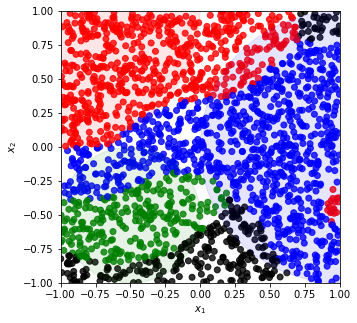

In [178]:
def train_multiclass_classifier(x, y, classifier, opt, epochs, batch=None, verbose=True):
    """ Train a quantum binary classifier.

    Args:
        x (np.array): Array of training values.
        y (np.array): Array of training targets.
        layers (int): Num of quantum layers.
        opt (optimiser): Optimiser implementing the `step()` function.
        epochs (int): Training epochs.
        batch (int): Size of training batches, deafult batch is len(x).
        
    Returns:
        param: Array of optimal parameters
    """
    if verbose:
        print('Beginning training')
    # Map classes 
    class_map = map_four_classes(set(y))

    params = []
    for dim in classifier.get_params_dim():
        params.append(np.random.uniform(size=dim))

    # Append class weights
    params.append(np.random.uniform(size=(4,1)))
        
    train_costs = []
    train_scores = []
    for it in range(epochs):
        for Xbatch, ybatch in iterate_minibatches(x, y, batch_size=batch):
            params = opt.step(lambda v: multiclass_cost_weighted_fixed(v, Xbatch, ybatch, class_map, classifier), params)            

        y_ = multiclass_predict(params, x, class_map, classifier)
        score = accuracy_score(y_, y)
        train_scores.append(score)
        if verbose:
            print(f't:{it} | accuracy: {score}')
    return params, class_map, train_scores

learning_rate = 0.7
epochs = 10
batch_size = 20

layers = 4

num_training = 300
num_test = 2000
x, y = three_circles(num_training)
x_test, y_test = three_circles(num_test)


opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
classifier = SingleQubitWeightedClassifier(layers=layers)
params_opt, class_map, train_scores = train_multiclass_classifier(x, y, classifier, opt, epochs, batch=20, verbose=True)

# params = None
# params = (np.random.uniform(size=(layers, 3)), np.random.uniform(size=(layers, 3)), np.random.uniform(size=(4, 1)))


# class_map = map_four_classes(set(y))

# y_ = multiclass_predict(params, x, class_map)
# plot_data(x, y_)

# train_costs = []
# train_scores = []
# for it in range(epochs):
#     for Xbatch, ybatch in iterate_minibatches(x, y, batch_size=batch_size):
#         params = opt.step(lambda v: multiclass_cost_weighted_fixed(v, Xbatch, ybatch, class_map), params)            
        
#     y_ = multiclass_predict(params, x, class_map)
#     score = accuracy_score(y, y_)
#     train_costs.append(cost)
#     train_scores.append(score)
#     print(f't:{it} | cost: {cost} | accuracy: {score}')
 
y_test_ = multiclass_predict(params_opt, x_test, class_map, classifier)
plot_data(x_test, y_test_)

The figure above shows the network is capabale (trained with a fixed equal class weights) of determining some structure in the data, although the current results are limited by the number of points used in training as a consequence of slow computation. However, with further refinement to the code and moving to a production design would increase code performance and allow a better evaluation of the methodologies provided.

## Moving Forward

The previous code is written as research code and the reusabilty would be much improved by extending on the class structure of the classifiers to better encapsulate all the elements of the classification, this would include containing the data structures such as the class maps, and methods such as train and predict.

Part of the slow speed is due to the gradient computations by AutoGrad, which also limits the design implementation. It would be interesting to see if results can be improved by using a gradient free heuristic search algorithm such as differential evolution.

The previosuly presented methodologies also lack validiation, which would also help improve classification performance. It would also benefit from hyperparameter tuning to help optimiser performance. 

The models presented can be further extended by introducing multiqubit classifiers with entanglement.